In [15]:
import time
import random
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, models, transforms
from torchinfo import summary
from PIL import Image
import matplotlib.pyplot as plt
torch.manual_seed(30)

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = 'data/plantvillage'
image_datasets = datasets.ImageFolder(root=data_dir)
class_names = image_datasets.classes
print(f'Number of Classes: {len(class_names)}\nData set class names: \n{class_names}')

Number of Classes: 38
Data set class names: 
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites 

In [17]:
train, val, test = torch.utils.data.random_split(image_datasets, [0.9, 0.05, 0.05])
print(f'No of train: {len(train)} | No of val: {len(val)} | No of test: {len(test)} | ')

No of train: 48875 | No of val: 2715 | No of test: 2715 | 


In [18]:
# data transforms
mean =  np.array([0.4664, 0.4891, 0.4104])
std =  np.array([0.1761, 0.1500, 0.1925])

data_transformer = {
	'train':
		transforms.Compose([
		transforms.RandomResizedCrop(244),
		transforms.RandomHorizontalFlip(),
		transforms.ToTensor(),
		transforms.Normalize(mean, std)
	]),
	'val':
		transforms.Compose([
		transforms.CenterCrop(244),
		transforms.ToTensor(),
		transforms.Normalize(mean, std)
	])
}

# Reverse normalization function
def reverse_normalize(image, mean, std):
    """
    Reverse normalization of an image.
    Args:
        image (Tensor): Normalized image tensor (C, H, W).
        mean (tuple): Mean values for each channel.
        std (tuple): Standard deviations for each channel.
    Returns:
        image (ndarray): Denormalized image.
    """
    mean = np.array(mean)
    std = np.array(std)
    image = image.cpu().numpy().transpose((1, 2, 0))
    image = std * image + mean
    image = np.clip(image, 0, 1)
    return image

In [19]:
class PlantVillageDataset(Dataset):
	def __init__(self, datasets, transform=None):
		self.dataset = datasets
		self.transform = transform
		
	def __getitem__(self, index):
		if self.transform:
			x = self.transform(self.dataset[index][0])
		else:
			x = self.dataset[index][0]
		y = self.dataset[index][1]
		return x, y

	def __len__(self):
		return len(self.dataset)

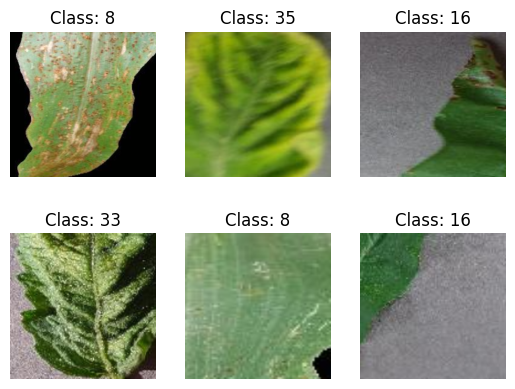

In [20]:
train_data = PlantVillageDataset(train, data_transformer['train'])
val_data = PlantVillageDataset(val, data_transformer['val'])
test_data = PlantVillageDataset(test, data_transformer['val'])

# Preview transformed images
for i in range(6):
    plt.subplot(2, 3, i+1)
    image, label = train_data[i]
    image = reverse_normalize(image, mean, std)
    plt.imshow(image)
    plt.title(f'Class: {label}')
    plt.axis('off')

plt.show()


In [21]:
#hyperparameters
n_classes = 38
n_epochs = 15
batch_size = 64
learning_rate = 0.001


In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
class ConvNet(nn.Module):
	def __init__(self):
		super(ConvNet, self).__init__()
		self.fc_dim = 7744
		self.n_classes = 38
		self.sequential1 = nn.Sequential(
			nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2, stride=2)
		)
		self.sequential2 = nn.Sequential(
			nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2, stride=2)
		)
		self.sequential3 = nn.Sequential(
			nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2, stride=2)
		)
		self.sequential4 = nn.Sequential(
			nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2, stride=2)
		)
		self.sequential5 = nn.Sequential(
			nn.Linear(self.fc_dim, 256),
			nn.ReLU(),
			nn.Dropout(0.3),
			nn.Linear(256, 128),
			nn.ReLU(),
			nn.Dropout(0.2),
			nn.Linear(128, 64),
			nn.ReLU(),
			nn.Dropout(0.1),
			nn.Linear(64, self.n_classes),
			# (n + 2p -f)/s + 1
		)
			
	def forward(self, x):
		out = self.sequential1(x)
		out = self.sequential2(out)
		out = self.sequential3(out)
		out = self.sequential4(out)
		out = out.view(out.size(0), -1)
		out = self.sequential5(out)
		return out
	
model = ConvNet().to(device)
print(summary(model))
# use two gpu
model = torch.nn.DataParallel(model, device_ids = [0,1]).to(device)

Layer (type:depth-idx)                   Param #
ConvNet                                  --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       456
│    └─ReLU: 2-2                         --
│    └─MaxPool2d: 2-3                    --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-4                       2,416
│    └─ReLU: 2-5                         --
│    └─MaxPool2d: 2-6                    --
├─Sequential: 1-3                        --
│    └─Conv2d: 2-7                       12,832
│    └─ReLU: 2-8                         --
│    └─MaxPool2d: 2-9                    --
├─Sequential: 1-4                        --
│    └─Conv2d: 2-10                      51,264
│    └─ReLU: 2-11                        --
│    └─MaxPool2d: 2-12                   --
├─Sequential: 1-5                        --
│    └─Linear: 2-13                      1,982,720
│    └─ReLU: 2-14                        --
│    └─Dropout: 2-15                     --
│    └─L

In [23]:
train_data_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
val_data_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_data_loader = DataLoader(test_data, batch_size=1, shuffle=True)

In [24]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
start_time = time.time()
n_total_steps = len(train_data_loader)
losses = []
print(f'\n {"="*30}')
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_data_loader):
        images = images.to(device)
        labels = labels.to(device)
        
        #forward
        outputs = model(images)
        loss = criterion(outputs, labels)
        #backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    # if(epoch + 1) % 10 == 0:
    losses.append(loss.item())
    print(f'| Epoch: {epoch+1}/{n_epochs}\t| Loss: {loss.item():.4f} |')
print(f' {"="*30}\n')
end_time = time.time() - start_time
#test
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    for images, labels in val_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        _, predictions = torch.max(outputs, 1)
        n_samples += labels.shape[0]
        n_correct += (predictions == labels).sum().item()
    accuracy = n_correct * 100.0 / n_samples
    print(f'\tAccuracy: {accuracy:.2f}%')
print(f'\n {"="*30}\n')
print(f'  Training Time: {end_time/60:.2f} Minute(s)')
print(f'\n {"="*30}\n')
plt.plot(losses)
plt.show()

In [25]:
save_path = 'models/plantvillage.pth'
# torch.save(model.module.state_dict(), save_path)

In [26]:
save_path = 'models/plantvillage.pth'
device = torch.device('cpu')
# torch.save(model.module.state_dict(), save_path)
plantVillageModel = ConvNet()
plantVillageModel.load_state_dict(torch.load(save_path, map_location=torch.device('cpu')))
plantVillageModel.eval()
plantVillageModel.to(device)

ConvNet(
  (sequential1): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (sequential2): Sequential(
    (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (sequential3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (sequential4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (sequential5): Sequential(
    (0): Linear(in_features=7744, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
 

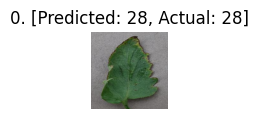

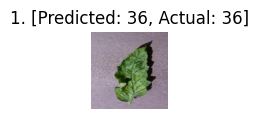

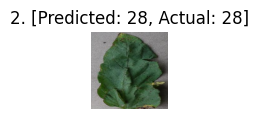

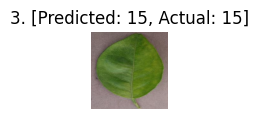

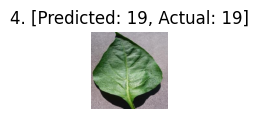

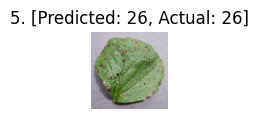

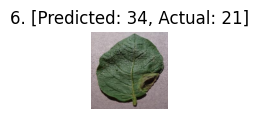

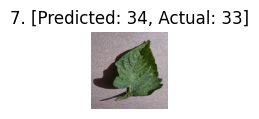

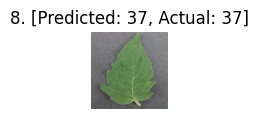

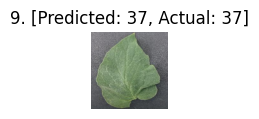

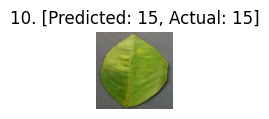

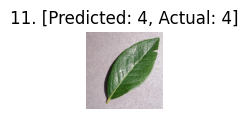

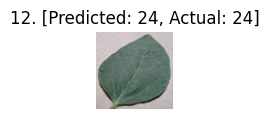

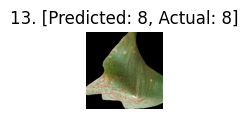

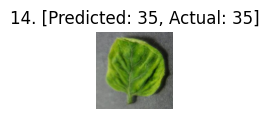

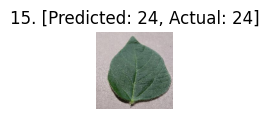

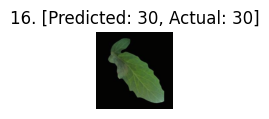

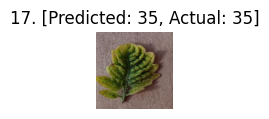

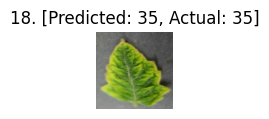

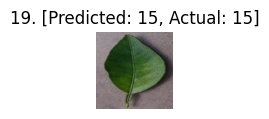

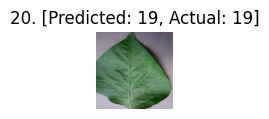

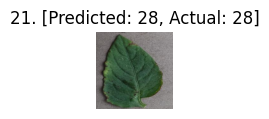

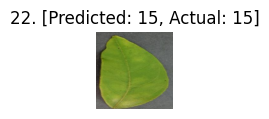

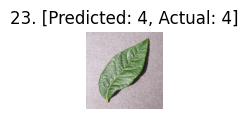

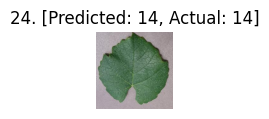

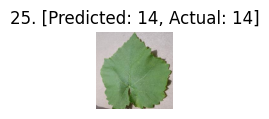

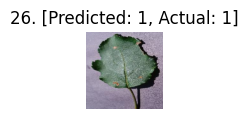

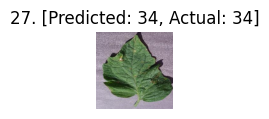

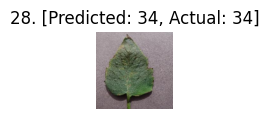

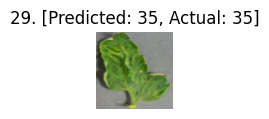

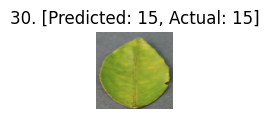

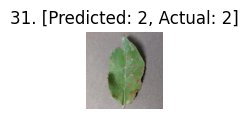

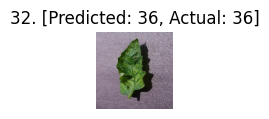

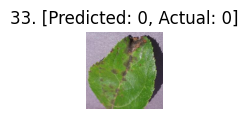

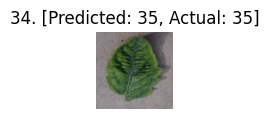

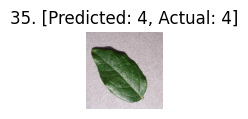

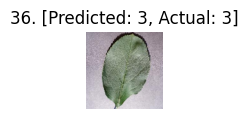

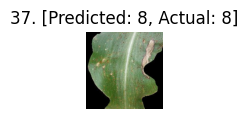

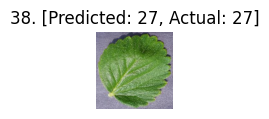

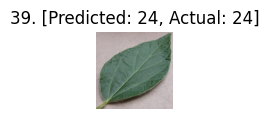

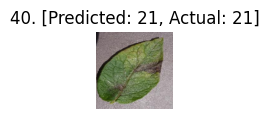

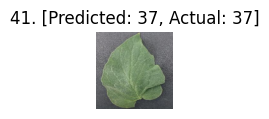

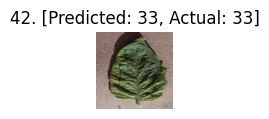

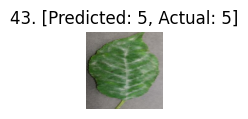

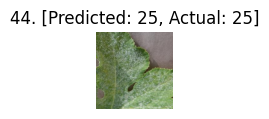

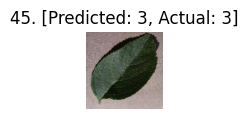

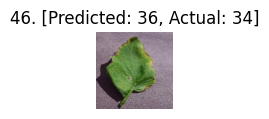

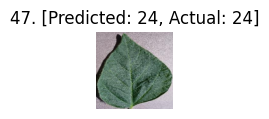

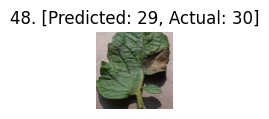

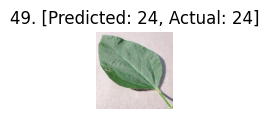

Total Correct Predictions: 46
Total Wrong Predictions: 4
Test Set Accuracy: 92.0%


In [30]:
# Test Evaluation
#test_data_loader = DataLoader(test_data, batch_size=1, shuffle=True)
test_sample_count = 50  # Changed to pick two images
n_samples = len(test_data_loader.dataset)  # Assuming test_data_loader is a DataLoader object with a dataset attribute

correct_count = 0
wrong_count = 0

for i in range(test_sample_count):
    random_index = random.randint(0, len(test_data_loader) - 1)
    for idx, (images, labels) in enumerate(test_data_loader):
        if idx == random_index:
            image = images
            label = labels
            break
    
    image = image.to(device)
    label = label.to(device)
    with torch.no_grad():
        output = plantVillageModel(image)
    _, prediction = torch.max(output, 1)
    
    # Check if prediction is correct
    is_correct = (prediction == label)
    correct_count += is_correct.item()
    wrong_count += int(not is_correct.item())

    # Convert tensors to numpy arrays and reverse normalization
    image = reverse_normalize(image.squeeze(), mean, std)
    label = label.item()
    prediction = prediction.item()
    
    # Plot the image along with its label
    plt.figure(figsize=(1, 1))
    plt.imshow(image)
    plt.title(f'{i}. [Predicted: {prediction}, Actual: {label}]')
    plt.axis('off')
    plt.show()

# Print the total counts
print(f'Total Correct Predictions: {correct_count}')
print(f'Total Wrong Predictions: {wrong_count}')
print(f'Test Set Accuracy: {(correct_count/test_sample_count)*100}%')

In [31]:
import torch
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt

class ImageClassPredict:
	def __init__(self, model, model_path, image_path):
		self.model = model
		self.model.load_state_dict(torch.load(model_path, map_location=device))
		self.model.eval()
		self.device = torch.device('cpu')
		self.image_transformer = transforms.Compose([
			transforms.CenterCrop(244),
			transforms.ToTensor(),
			transforms.Normalize(mean, std)
		])
		self.model_path = model_path
		self.image = self.load_image(image_path)
		self.infer()


	def load_image(self, image_path):
		image = Image.open(image_path).convert('RGB')  # Load the image using PIL and convert to RGB
		image = self.image_transformer(image)  # Apply data transformations
		return image


	def infer(self):
		with torch.no_grad():
			output = self.model(self.image.unsqueeze(0))  # Unsqueeze to add batch dimension
		_, prediction = torch.max(output, 1)
		prediction_idx = prediction.item()  # Return the predicted class index
		return self.class_names_map(class_names, prediction_idx)
	
	def class_names_map(self, class_list, prediction):
		return class_list[prediction]



Corn_(maize)___Northern_Leaf_Blight


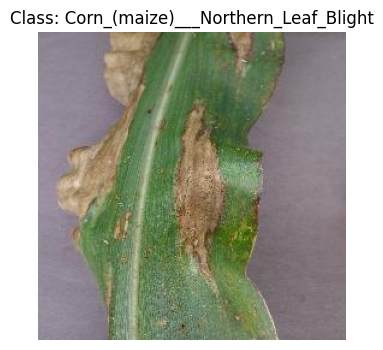

In [29]:
# Image path
img_path = 'data/plantvillage/Corn_(maize)___Northern_Leaf_Blight/022817bd-6a93-4b0a-ac39-1cc4094128b1___RS_NLB 3476.JPG'
model_path = 'models/plantvillage.pth'


# Initialize the predictor with the model
prediction = ImageClassPredict(ConvNet(), model_path, img_path).infer()

print(prediction)
# Plot the image
im = Image.open(img_path)
plt.figure(figsize=(4, 4))
plt.imshow(im)
plt.title(f'Class: {prediction}')
plt.axis('off')
plt.show()


In [18]:

import json
class_names = [
    "Apple___Apple_scab",
    "Apple___Black_rot",
    "Apple___Cedar_apple_rust",
    "Apple___healthy",
    "Blueberry___healthy",
    "Cherry_(including_sour)___Powdery_mildew",
    "Cherry_(including_sour)___healthy",
    "Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot",
    "Corn_(maize)___Common_rust_",
    "Corn_(maize)___Northern_Leaf_Blight",
    "Corn_(maize)___healthy",
    "Grape___Black_rot",
    "Grape___Esca_(Black_Measles)",
    "Grape___Leaf_blight_(Isariopsis_Leaf_Spot)",
    "Grape___healthy",
    "Orange___Haunglongbing_(Citrus_greening)",
    "Peach___Bacterial_spot",
    "Peach___healthy",
    "Pepper,_bell___Bacterial_spot",
    "Pepper,_bell___healthy",
    "Potato___Early_blight",
    "Potato___Late_blight",
    "Potato___healthy",
    "Raspberry___healthy",
    "Soybean___healthy",
    "Squash___Powdery_mildew",
    "Strawberry___Leaf_scorch",
    "Strawberry___healthy",
    "Tomato___Bacterial_spot",
    "Tomato___Early_blight",
    "Tomato___Late_blight",
    "Tomato___Leaf_Mold",
    "Tomato___Septoria_leaf_spot",
    "Tomato___Spider_mites Two-spotted_spider_mite",
    "Tomato___Target_Spot",
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus",
    "Tomato___Tomato_mosaic_virus",
    "Tomato___healthy"
]

class_dict = {index: class_name for index, class_name in enumerate(class_names)}


# Convert and write JSON object to file
with open("class_names.json", "w") as outfile:
	json.dump(class_dict, outfile)